In [13]:
# Import libraries
import pandas as pd
import datetime as dt
import os
import h5py
import numpy as np
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables
cmap = ctables.registry.get_colortable('precipitation')
import xarray as xr

In [26]:
# Enter time and Location

start_str = "2017-08-25 00:00:00"
end_str = "2017-09-01 00:00:00"

times_pd = pd.date_range(start=start_str,end=end_str, freq='30min')
times_pd = times_pd[0:-1]
desired_lon = -94.12
desired_lat = 30.08

In [27]:
filepaths = []
for i in times_pd: # Download all the desired IMERG Images
    # If IMERG file does not exist, download it
    
    year = i.year
    day_of_year = i.strftime('%j')
    day_stripped = i.strftime('%Y%m%d')
    time_stripped = i.strftime('%H%M%S')
    min_of_day = str(i.hour*60 + i.minute).zfill(4)
    end_time_stripped = (i+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')
        
    IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
            '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
            '.'+min_of_day+'.V07B.HDF5'  

# If day directory does not exist, make day directory
    if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
        os.mkdir('/Users/acheung/data/IMERG/'+str(year))

    if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
        os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

    if os.path.exists(IMERG_file_path) == False:
        url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
            +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
            '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
        os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + url_desired)
    filepaths.append(IMERG_file_path)


In [28]:
for case_loop in range(len(filepaths)): # Run all
# for case_loop in [18]: # Run all
    fn = filepaths[case_loop]
    print(fn)
    try:
        f = h5py.File(fn, 'r')
    except: # If the file is corrupt, remove and re-download
        os.system('rm ' + fn)
        os.chdir(fn[0:35])
        new_url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/' + fn[26:]
        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + new_url)
        f = h5py.File(fn, 'r')
        
    # Work on precip file
    groups = [ x for x in f.keys() ]
    # print(groups)
    gridMembers = [ x for x in f['Grid'] ]
    # print(gridMembers)

    # Get the precipitation, latitude, and longitude variables
    precip = f['Grid/precipitation'][0][:][:]
    precip = np.transpose(precip)
    precip[precip<-999]=np.nan

    theLats = f['Grid/lat'][:]
    theLons = f['Grid/lon'][:]
    x, y = np.float32(np.meshgrid(theLons, theLats))

    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x, y,(desired_lon,desired_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))
    
    # Slice arrays to within 30 indices of desired center

    sliced_lon_grid = x[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    sliced_lat_grid = y[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    sliced_precip = precip[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    if case_loop == 0:
        total_precip = sliced_precip * 0.5
    else:
        total_precip = total_precip + (sliced_precip * 0.5)

/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S000000-E002959.0000.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S003000-E005959.0030.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S010000-E012959.0060.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S013000-E015959.0090.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S020000-E022959.0120.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S023000-E025959.0150.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S030000-E032959.0180.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S033000-E035959.0210.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S040000-E042959.0240.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HHR.MS.MRG.3IMERG.20170825-S043000-E045959.0270.V07B.HDF5
/Users/acheung/data/IMERG/2017/237/3B-HH

Text(0.5, 1.0, 'start = 2017-08-25 00:00:00, end = 2017-09-01 00:00:00')

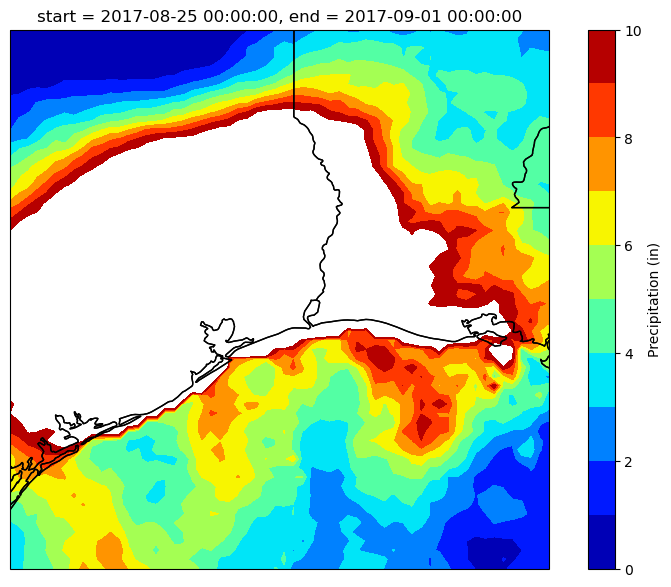

In [29]:
# Make the figure larger
fig = plt.figure(figsize=(10,7))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
clevs=[0.01,0.10,0.25,0.5,1,1.5,2,3,4,5,6,7,8,10,12,14,16,18,20,24,28,32,36,40]
imerg_plot = ax.contourf(sliced_lon_grid,sliced_lat_grid,total_precip/25.4,
            transform = ccrs.PlateCarree(),levels=np.arange(0,10.1,1),cmap='jet') # Convert units from mm to inches by dividing

# Add coastlines
# ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(imerg_plot,label='Precipitation (in)')
plt.title('start = ' + start_str + ', end = ' + end_str)


In [30]:
sliced_lon_grid,sliced_lat_grid,total_precip

(array([[-97.15    , -97.049995, -96.95    , ..., -91.45    , -91.35    ,
         -91.25    ],
        [-97.15    , -97.049995, -96.95    , ..., -91.45    , -91.35    ,
         -91.25    ],
        [-97.15    , -97.049995, -96.95    , ..., -91.45    , -91.35    ,
         -91.25    ],
        ...,
        [-97.15    , -97.049995, -96.95    , ..., -91.45    , -91.35    ,
         -91.25    ],
        [-97.15    , -97.049995, -96.95    , ..., -91.45    , -91.35    ,
         -91.25    ],
        [-97.15    , -97.049995, -96.95    , ..., -91.45    , -91.35    ,
         -91.25    ]], dtype=float32),
 array([[27.05, 27.05, 27.05, ..., 27.05, 27.05, 27.05],
        [27.15, 27.15, 27.15, ..., 27.15, 27.15, 27.15],
        [27.25, 27.25, 27.25, ..., 27.25, 27.25, 27.25],
        ...,
        [32.75, 32.75, 32.75, ..., 32.75, 32.75, 32.75],
        [32.85, 32.85, 32.85, ..., 32.85, 32.85, 32.85],
        [32.95, 32.95, 32.95, ..., 32.95, 32.95, 32.95]], dtype=float32),
 array([[ 79.77001  , 

In [31]:
da = xr.DataArray(
    data=total_precip,
    dims=["lon", "lat"],
    coords=dict(
        lon=(["lon", "lat"], sliced_lon_grid),
        lat=(["lon", "lat"], sliced_lat_grid),
        time='start = ' + start_str + ', end = ' + end_str,
    ),
    attrs=dict(
        description="IMERG Precip Total",
        units="mm",
    ),
)

da.to_netcdf('/Users/acheung/data/intermediates/start = ' + start_str + ', end = ' + end_str + ' imerg.nc')

In [32]:
da

<xarray.DataArray (lon: 60, lat: 60)> Size: 14kB
array([[ 79.77001  ,  95.05503  , 110.28999  , ...,  30.125    ,
         39.789993 ,  44.24499  ],
       [ 80.36999  ,  91.87504  , 109.125015 , ...,  32.574997 ,
         43.095    ,  48.950012 ],
       [ 82.945    ,  91.93005  , 109.81     , ...,  40.405006 ,
         48.75002  ,  42.895008 ],
       ...,
       [  4.615    ,   4.8199997,   5.7200007, ...,  76.06001  ,
         71.494995 ,  71.19     ],
       [  4.2749996,   3.4950001,   3.6399999, ...,  68.46501  ,
         56.054993 ,  64.700005 ],
       [  4.6749997,   4.61     ,   4.3199997, ...,  69.39498  ,
         55.31499  ,  56.839996 ]], dtype=float32)
Coordinates:
    lon      (lon, lat) float32 14kB -97.15 -97.05 -96.95 ... -91.35 -91.25
    lat      (lon, lat) float32 14kB 27.05 27.05 27.05 ... 32.95 32.95 32.95
    time     <U54 216B 'start = 2017-08-25 00:00:00, end = 2017-09-01 00:00:00'
Attributes:
    description:  IMERG Precip Total
    units:        mm